## Purpose of this notebook
In this notebook we will merge the 4 intermediate tables, delete rows and columns with majority missing entries and prepare the data for EDA.

In [27]:
import pandas as pd
import numpy as np
dem_df = pd.read_csv('../../data/intermediate/inter022020.csv')
serv_cpt_df = pd.read_csv('../../data/intermediate/inter022020a.csv')
lab_df = pd.read_csv('../../data/intermediate/inter022020b.csv')
diag_df = pd.read_csv('../../data/intermediate/inter022120.csv')
print(dem_df.values.shape)
print(serv_cpt_df.values.shape)
print(lab_df.values.shape)
print(diag_df.values.shape)

(37812, 14)
(58926, 83)
(53791, 1039)
(58890, 205)


In [28]:
print("After merging we should have 37812 rows and ", 14+83+1039+205-3, " columns.") # -3 is for index column

After merging we should have 37812 rows and  1338  columns.


In [29]:
combined_df = dem_df.merge(serv_cpt_df, left_on='HADM_ID', right_on='HADM_ID', how='left')
combined_df = combined_df.merge(lab_df, left_on='HADM_ID', right_on='HADM_ID', how='left')
combined_df = combined_df.merge(diag_df, left_on='HADM_ID', right_on='HADM_ID', how='left')
assert combined_df.values.shape == (37812, 1338), "something doesn't add up"

Text(0.5, 1.0, 'Dataframe missing values survey')

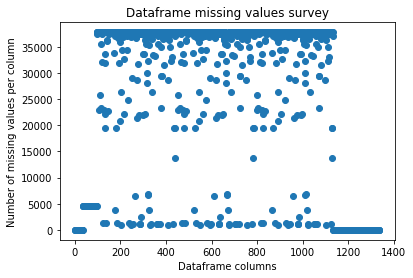

In [30]:
import matplotlib.pyplot as plt
# next we need to quantify the number of missing values for each column
missing_val_array = combined_df.isnull().sum()
num_cols = len(combined_df.columns.tolist())
plt.scatter(range(num_cols), missing_val_array)
plt.xlabel("Dataframe columns")
plt.ylabel("Number of missing values per column")
plt.title("Dataframe missing values survey")

In [31]:
# let's set a threshold at 37812*0.33, i.e. we will impute 1/3rd of the values, this is certainly one of the 
# parameters to alter. Drop any columns that are missing > 2/3 of values
list_of_cols = combined_df.columns.tolist()
cols_to_drop = [column for column in list_of_cols if missing_val_array[list_of_cols.index(column)]>37812*2/3]
combined_df.drop(columns=cols_to_drop, inplace=True)
print("The size of the remaining dataframe is ", combined_df.values.shape)

The size of the remaining dataframe is  (37812, 423)


Text(0.5, 1.0, 'Dataframe null values survey')

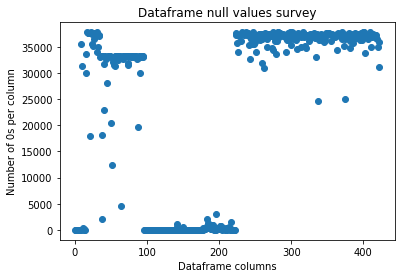

In [32]:
# next we need to eliminate columns that consist of mostly 0s
zero_val_array = (combined_df == 0).astype(int).sum(axis=0)
num_cols = len(combined_df.columns.tolist())
plt.scatter(range(num_cols), zero_val_array)
plt.xlabel("Dataframe columns")
plt.ylabel("Number of 0s per column")
plt.title("Dataframe null values survey")

In [34]:
# let's see the counts of non-readmitted and readmitted labels
combined_df.groupby('OUTPUT_LABEL')['HADM_ID'].count()

OUTPUT_LABEL
0.0    35517
1.0     2295
Name: HADM_ID, dtype: int64

In [35]:
# we have ~2300 positive labels, it is possible that there is a variable with all 0s for label 0 and 1s for label 1,
# the count of 0 values for this variable will be >35000, which is the ideal case. We will look at mutual information
# in the next analysis - EDA. In here we will delete columns that consist of > 37812 - 0.1*2295 0s.
list_of_cols = combined_df.columns.tolist()
cols_to_drop = [column for column in list_of_cols if zero_val_array[list_of_cols.index(column)]>(37812 - 0.1*2295)]
combined_df.drop(columns=cols_to_drop, inplace=True)
print("The size of the remaining dataframe is ", combined_df.values.shape)

The size of the remaining dataframe is  (37812, 390)


In [24]:
# impute the rest of the valeus with the median value
combined_df = combined_df.fillna(combined_df.median())

# lets inspect the columns
combined_df.columns.tolist()

['Unnamed: 0_x',
 'HADM_ID',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 '1Y_PRIOR_ADM',
 'LENGTH_OF_STAY_DAYS',
 'GENDER',
 'AGE',
 'Unnamed: 0_y',
 'CURR_SERVICE_CMED',
 'CURR_SERVICE_CSURG',
 'CURR_SERVICE_MED',
 'CURR_SERVICE_SURG',
 'SECTIONHEADER_Anesthesia',
 'SECTIONHEADER_Emerging technology',
 'SECTIONHEADER_Evaluation and management',
 'SECTIONHEADER_Medicine',
 'SECTIONHEADER_Pathology and laboratory',
 'SECTIONHEADER_Radiology',
 'SECTIONHEADER_Surgery',
 'SUBSECTIONHEADER_Bone/joint studies',
 'SUBSECTIONHEADER_Cardiovascular',
 'SUBSECTIONHEADER_Cardiovascular system',
 'SUBSECTIONHEADER_Case management services',
 'SUBSECTIONHEADER_Central nervous system assessments/tests (neuro-cognitive, mental status, speech testing)',
 'SUBSECTIONHEADER_Chemistry',
 'SUBSECTIONHEADER_Confirmatory consultation for a new or established patient (deleted codes)',
 'SUBSECTIONHEADER_Conscious sedation (deleted co

In [25]:
# looks like some index columns have been preserved, delete the columns starting with "unnamed"
cols_to_drop = [column for column in combined_df.columns.tolist() if column.startswith('Unnamed')]
cols_to_drop

['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0']

In [26]:
combined_df.drop(columns=cols_to_drop, inplace=True)
combined_df.values.shape

(37812, 224)

In [ ]:
combined_df.to_csv('../../data/processed/processed_for_eda.csv')